In [4]:
import pandas as pd
import numpy as np
import librosa
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from scipy.io import wavfile
import seaborn as sns
import librosa.display

Read files: development and evaluation

In [5]:
X = pd.read_csv("dsl_data/development.csv")
X_ev = pd.read_csv("dsl_data/evaluation.csv")

Feature frequencies histograms

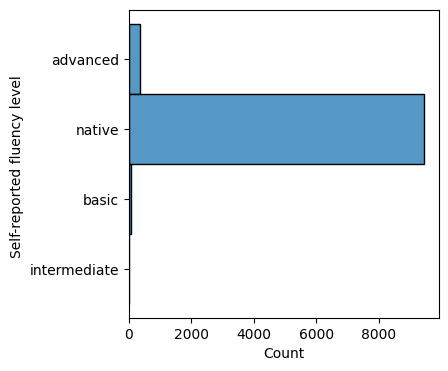

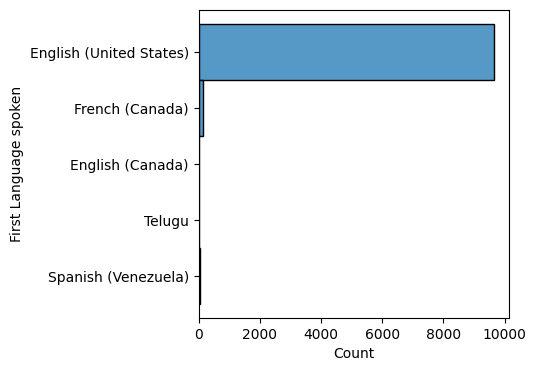

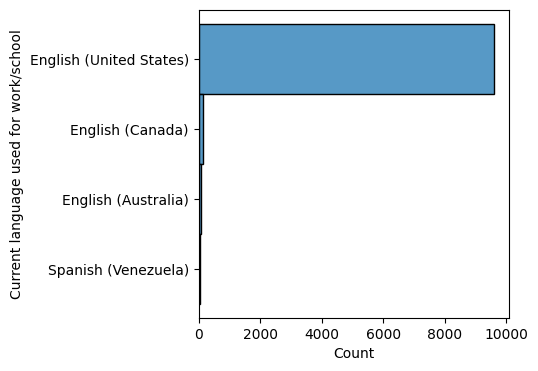

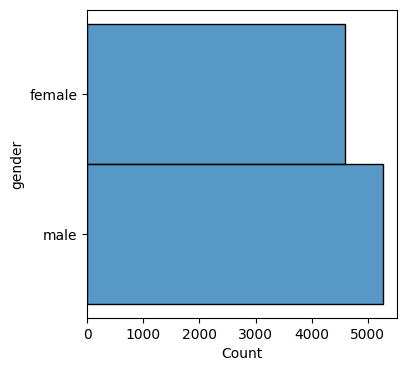

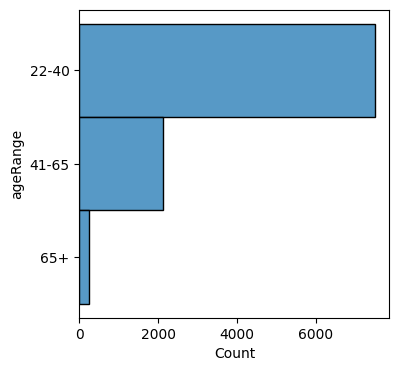

In [6]:
columns = [ col for col in X.columns if col not in ['Id', 'path', 'speakerId', 'action', 'object', 'signal' ] ]

for col in columns:
    fig, ax = plt.subplots(1, 1)
    sns.histplot(X, y = col, ax = ax)
    fig.set_size_inches(4, 4)
    plt.show()

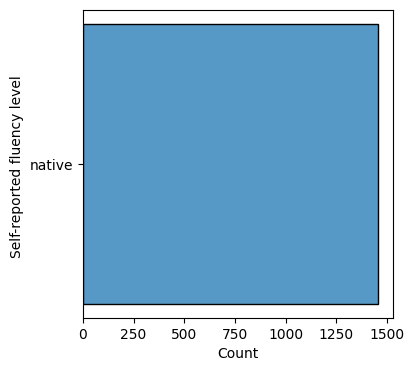

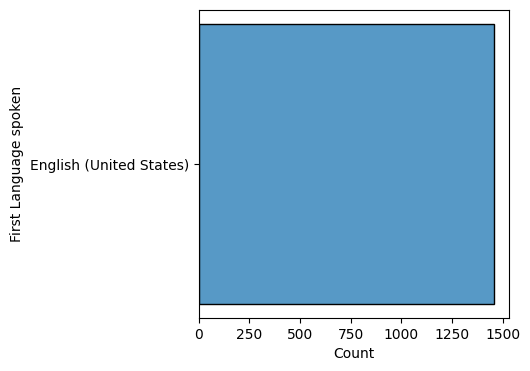

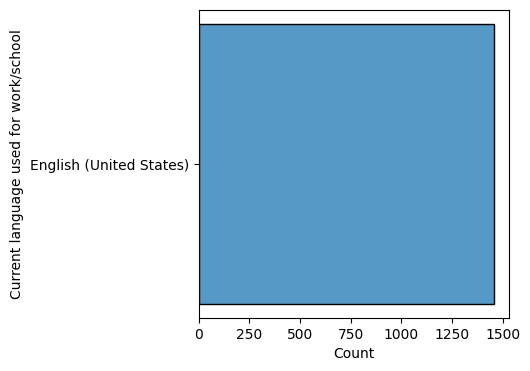

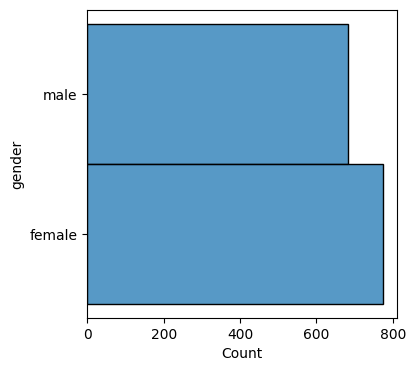

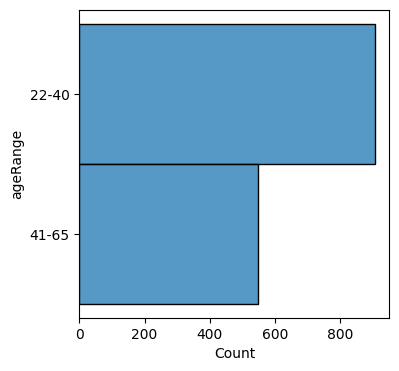

In [7]:
columns = [ col for col in X_ev.columns if col not in ['Id', 'path', 'speakerId', 'action', 'object', 'signal' ] ]

for col in columns:
    fig, ax = plt.subplots(1, 1)
    sns.histplot(X_ev, y = col, ax = ax)
    fig.set_size_inches(4, 4)
    plt.show()

Definition of the target label as action + object

In [8]:
action = X["action"]
object = X["object"]
y = []
for i in range(0, len(action)):
    y.append(str(action.iloc[i]) + str(object.iloc[i]))
X = X.drop(["action", "object"],  axis='columns')

Plot of the number of utterancies of each label

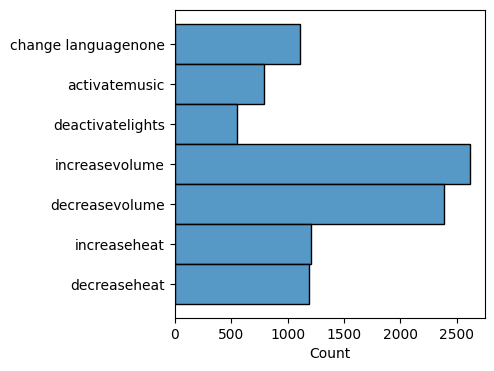

In [9]:
# intent is the combination of attribute action and object
intent = y
fig, ax = plt.subplots(1, 1)
sns.histplot(y = intent, ax = ax)
# ax.set_title('Intent distribution')
fig.set_size_inches(4, 4)
plt.show()

Read paths 

In [10]:
def read_path(X):
    path = X["path"]
    return path, X.drop("path",  axis='columns')
path, X = read_path(X)
path_ev, X_ev = read_path(X_ev)

Read audios with librosa library (resample of the audios in 16kHz)

In [11]:
def read_songs(path):
    X = []
    samplerates = []
    for p in path:
        data, samplerate  = librosa.load(p, sr=16000)
        samplerates.append(samplerate)
        X.append(data)
    return pd.Series(X), samplerates
X, samplerates = read_songs(path)
X_ev, samplerates_ev = read_songs(path_ev)

In [12]:
set(samplerates)

{16000}

Data exploration
===

Plot some audio inn time

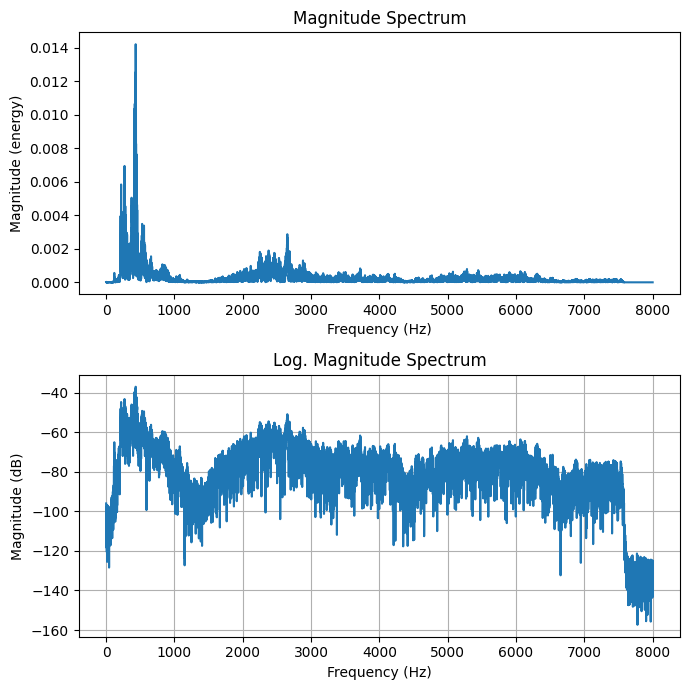

In [13]:
def plot_audio_time_freq(X, samplerates):
    np.random.seed(0)
    n = len(X[6505])
    T = n/samplerates[6505]
    t = np.arange(0,T,1/samplerates[6505])  

    s = X[6505]

    fig, (axs1, axs2) = plt.subplots(2, figsize=(7, 7))
    # plot different spectrum types:
    axs1.set_title("Magnitude Spectrum")
    axs1.magnitude_spectrum(s, Fs=samplerates[6505])
    axs1.set_xlabel("Frequency (Hz)")


    axs2.set_title("Log. Magnitude Spectrum")
    axs2.magnitude_spectrum(s, Fs=samplerates[6505], scale='dB')
    axs2.set_xlabel("Frequency (Hz)")

    plt.grid(True)
    fig.tight_layout()

    plt.show()
plot_audio_time_freq(X, samplerates)

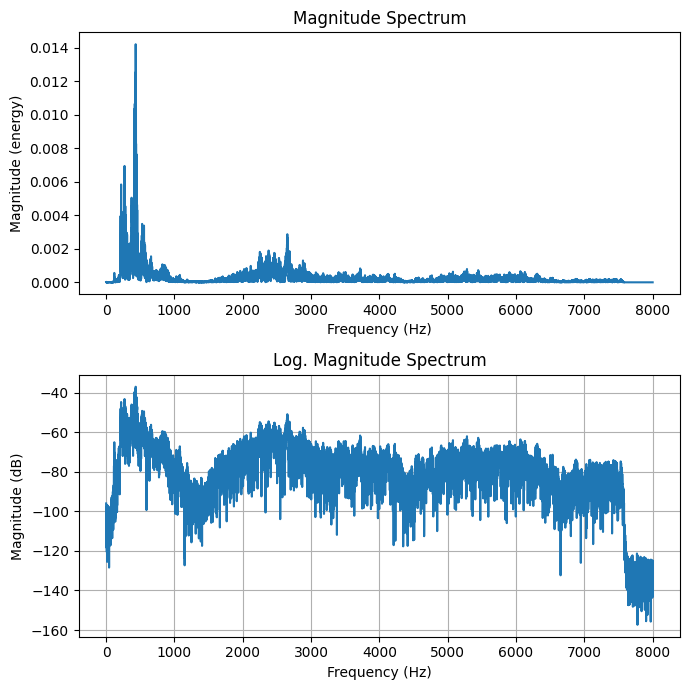

In [14]:
plot_audio_time_freq(X, samplerates)

Plot the melspectogram of an audio in db scale

/Users/luca/Library/Python/3.9/lib/python/site-packages/matplotlib/axes/_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


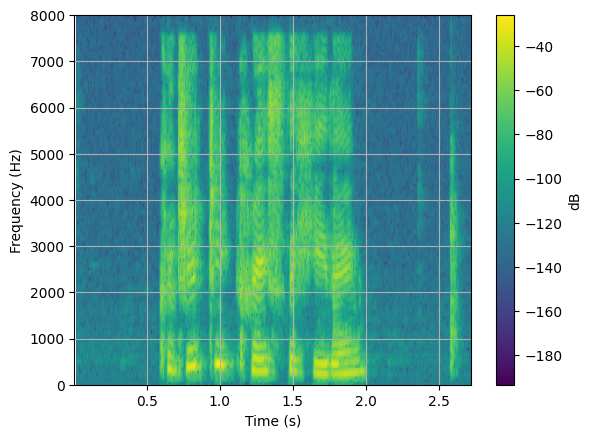

In [15]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(X[6505], Fs=samplerates[6505], scale = "dB")
cbar = plt.gcf().colorbar(imageAxis)
cbar.set_label('dB')
plt.grid()
#plt.suptitle("Spectrogram of a signal")
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()   

Listen an audio sample

In [16]:
import IPython.display as ipd

In [17]:
ipd.Audio(X[0], rate=samplerates[0])

Plot audio dataset durations

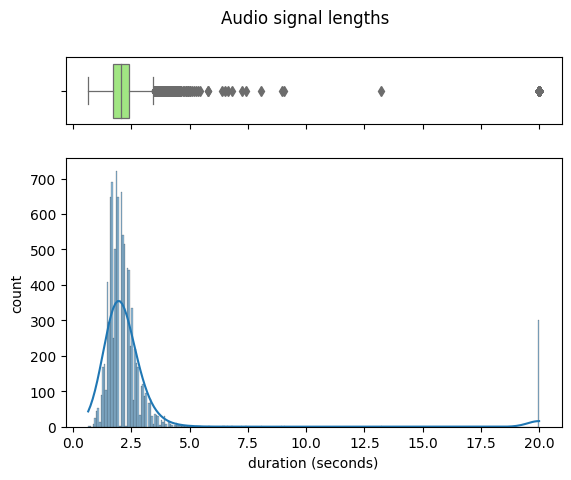

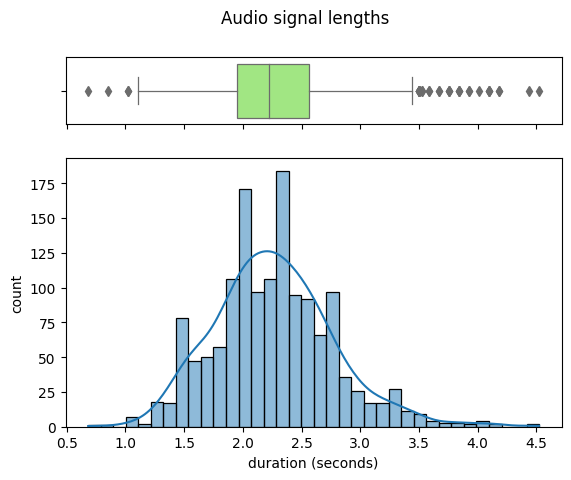

In [18]:
def show_length_distribution(signals, samplerates):
    srs = list(samplerates)
    sampel_times = [len(x)/srs[i] for i,x in enumerate(signals)]


    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)

    ax_box.set(xlabel='')


    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times


lengths = show_length_distribution(X, samplerates)
lengths_ev = show_length_distribution(X_ev, samplerates_ev)

Data processing
===

Remove silence

In [19]:
# anything below 20 db is considered as silence
# remove silence periods of audio signals
def remove_silence(sample, top_db = 20):
    yy = np.array(sample, dtype = np.float64)
    yt, _ = librosa.effects.trim(yy, top_db= top_db)
    return yt
X = [remove_silence(x) for x in X]
X_ev = [remove_silence(x) for x in X_ev]

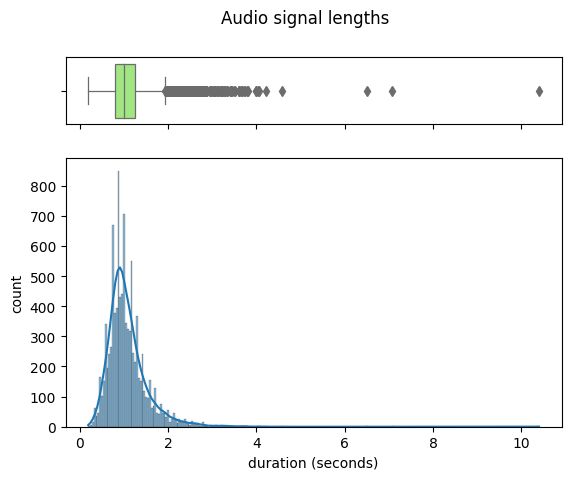

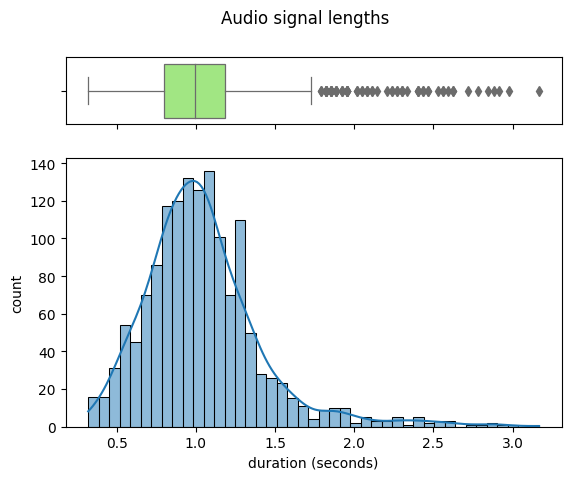

In [20]:
lengths = show_length_distribution(X, samplerates)
lenngths_ev = show_length_distribution(X_ev, samplerates_ev)

In [21]:
X = pd.Series(X)
X_ev = pd.Series(X_ev)
y = pd.Series(y)
samplerates = pd.Series(samplerates)
samplerates_ev = pd.Series(samplerates_ev)

Feature extraction
===

In [22]:
def extract_feature(X, n, samplerates):
    X_sp = [] #feature matrix
    for i, x in enumerate(X):
        sp = librosa.power_to_db(librosa.feature.melspectrogram(y=x, sr=samplerates.iloc[i]))
        x_sp = [] #current feature set
        # split the rows
        for v_split in np.array_split(sp, n, axis = 0):
            # split the columns
            for h_split in np.array_split(v_split, n, axis = 1):
                if h_split.size == 0: #happens when number of culumns < n
                    m = np.median(v_split).__round__(4)
                    sd = np.std(v_split).__round__(4)
                else:
                    m = np.mean(h_split).__round__(4)
                    sd = np.std(h_split).__round__(4)
                x_sp.extend([m,sd])
        ft2 = librosa.feature.zero_crossing_rate(y=x)
        ft3 = librosa.feature.spectral_rolloff(y=x, sr=16000)
        ft4 = librosa.feature.spectral_centroid(y=x, sr=16000)
        ft5 = librosa.feature.spectral_contrast(y=x, sr=16000)
        ft6 = librosa.feature.spectral_bandwidth(y=x, sr=16000)
        ft10 = librosa.feature.rms(y=x)
        ft11 = librosa.feature.spectral_flatness(y=x)
        ft12 = librosa.feature.chroma_stft(y=x, sr=16000)
        x_sp.extend([np.mean(ft2), np.std(ft2), np.mean(ft3), np.std(ft3), np.mean(ft4), np.std(ft4), np.mean(ft5), np.std(ft5), np.mean(ft6), np.std(ft6), np.mean(ft10), np.std(ft10), np.mean(ft11), np.std(ft11), np.mean(ft12), np.std(ft12)])
        X_sp.append(x_sp)
    return np.array(X_sp)

Hyperparameter tuning of n: please uncomment these cells to see the hyperparameter tuning calculation. It takes a lot of time

In [23]:
# models = {
#     "rfc": RFC(random_state=42),
#     "svm": Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC())])#,
# }
# scores = {}
# for n in range(2, 28, 2):
#     Z = extract_feature(X, n, samplerates)
#     X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size = 0.20, random_state = 42)
#     score = []
#     for model in models:
#         clf = models[model]
#         clf.fit(X_train, y_train)
#         y_pred = clf.predict(X_test)
#         a = accuracy_score(y_test, y_pred)
#         score.append((model, np.mean(a)))
#         print(score)
#     scores[n] = score

In [24]:
# rf_scores = [x[0][1] for x in scores.values()]
# svm_scores = [x[1][1] for x in scores.values()]
# #knn_scores = [x[2][1] for x in scores.values()]
# x = scores.keys()
# x_range = [4, 8, 12, 16,20, 24]
# y_range = np.arange(0.40, 1.1, 0.1)
# plt.plot(x, rf_scores, label = 'RF')
# plt.plot(x, svm_scores, label= 'SVM')
# #plt.plot(x, knn_scores, label= 'KNN')
# plt.grid(True)
# plt.legend()
# #plt.suptitle("Model evaluation on different n. of features")
# plt.xlabel("n")

# #plt.xscale(list(set(x)))
# plt.xticks(x_range)
# plt.yticks(y_range)
# plt.ylabel('Accuracy') #average or weighted?
# plt.show()

Extract MFCC feature

In [25]:
#12
Z = extract_feature(X, 12, samplerates)
print("----")
Z_ev = extract_feature(X_ev, 12, samplerates_ev)

/Users/luca/Library/Python/3.9/lib/python/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


----


Model selection: random forest with gridsearchCV

In [26]:
Xrf_train, Xrf_test, y_train, y_test = train_test_split(Z, y, test_size=0.20, random_state=42)

In [27]:
param_grid = {
    "n_estimators": [100,150,200],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.05,0.1]
}

clf = RFC(random_state = 42, n_jobs = -1 )
rf_search = GridSearchCV(clf, param_grid, scoring = "accuracy", cv = 5)
rf_search.fit(Xrf_train, y_train)

print("best Parameters for RF model:\n", rf_search.best_params_)
print("best score:", rf_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = rf_search.predict(Xrf_test)
print(accuracy_score(y_test, y_pred))

best Parameters for RF model:
 {'criterion': 'entropy', 'min_impurity_decrease': 0.0, 'n_estimators': 200}
best score: 0.6256481174497617


 Results on test dataset:


0.6615930999492643


Model selection: random forest with gridsearchCV

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(Z)
X_ev = scaler.transform(Z_ev)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [29]:
param_grid = {
    "C": [5,10,20],
    'kernel': ['rbf']
}

clf = svm.SVC( )
rf_search = GridSearchCV(clf, param_grid, scoring = "accuracy", cv = 5)
rf_search.fit(X_train, y_train)

print("best Parameters for SVC model:\n", rf_search.best_params_)
print("best score:", rf_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = rf_search.predict(X_test)
print(accuracy_score(y_test, y_pred))

best Parameters for SVC model:
 {'C': 10, 'kernel': 'rbf'}
best score: 0.7942389649433964


 Results on test dataset:


0.8168442415017757


Submission

In [30]:
y_ev_pred = rf_search.predict(X_ev)

In [31]:
f = open("submission_new.csv", "w")
f.write("Id,Predicted\n")
for i in range(0, len(y_ev_pred)):
    X
    str_ = str(i) + "," + str(y_ev_pred[i]) + "\n"
    f.write(str_)
f.close()